# Projeto 2 - Ciência dos Dados
## 2020.2 ~ 2C ~ Estudo do stat "Velocidade" dos Pokémons
### Grupo:
    -Guilherme Rameh
    -Tales Oliveira
    -Gabriella Zullo
    -João Magalhães

In [1]:
import scipy.stats as stats
from scipy.stats import t, norm, probplot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt, ceil
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

# Para ter melhor print
from IPython.display import display

In [2]:
# Leitura do banco de dados

dados = pd.read_csv('pokemon.csv')
dados

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,['Beast Boost'],0.25,1.0,0.5,2.0,0.5,1.0,2.0,0.5,1.0,...,NaN,797,107,101,61,steel,flying,999.9,7,1
797,['Beast Boost'],1.00,1.0,0.5,0.5,0.5,2.0,4.0,1.0,1.0,...,NaN,798,59,31,109,grass,steel,0.1,7,1
798,['Beast Boost'],2.00,0.5,2.0,0.5,4.0,2.0,0.5,1.0,0.5,...,NaN,799,97,53,43,dark,dragon,888.0,7,1
799,['Prism Armor'],2.00,2.0,1.0,1.0,1.0,0.5,1.0,1.0,2.0,...,NaN,800,127,89,79,psychic,NaN,230.0,7,1


# Primeira Análise Exploratória
A seguir, verificaremos quais variáveis achamos interessantes de se relacionar com a velocidade dos Pokémons, que é nossa variável *Target*. Começamos printando as colunas do dataframe, pois sabendo do que se trata, podemos descartar algumas colunas logo de cara (como por exemplo as colunas referentes a quanto de dano cada ataque dá em cada tipo de Pokémon).

In [3]:
print(dados.dtypes)

abilities             object
against_bug          float64
against_dark         float64
against_dragon       float64
against_electric     float64
against_fairy        float64
against_fight        float64
against_fire         float64
against_flying       float64
against_ghost        float64
against_grass        float64
against_ground       float64
against_ice          float64
against_normal       float64
against_poison       float64
against_psychic      float64
against_rock         float64
against_steel        float64
against_water        float64
attack                 int64
base_egg_steps         int64
base_happiness         int64
base_total             int64
capture_rate          object
classfication         object
defense                int64
experience_growth      int64
height_m             float64
hp                     int64
japanese_name         object
name                  object
percentage_male      float64
pokedex_number         int64
sp_attack              int64
sp_defense    

<b> Lembrete: Quando lidando com duas variáveis QUANTITATIVAS, usamos scatter plot, e para variáveis QUALITATÍVAS (como estamos lidando com "speed", que é quantitativo) podemos separar por index e fazer crosstab, ou usar o comando pivot table do pandas, que permite a análise de várias variáveis qualitativas em relação a quantitativas, permitindo até o uso de comandos como média, máx e mín.

### Primeiras modificações no Dataframe

A seguir, manipulamos o dataframe com o intuito de analisar a relação da velocidade com as principais variáveis quantitativas, como ataque, defesa, etc...; Para evitar confusões e dificuldade na leitura dos gráficos, primeiro separamos os tipos de pokémons nos mais frequentes, tanto para o *tipo 1* quanto para o *tipo 2*. Nessa etapa também separamos o dataframe em dois, um de treino e um para testarmos o quão fíel é o nosso modelo.

In [4]:
for i in dados.index:
    type1 = dados.type1[i]
    if type1 == 'water':
        dados.loc[dados.index==i, 'Type1Reorder'] = 'water'
    elif type1 == 'normal':
        dados.loc[dados.index==i, 'Type1Reorder'] = 'normal'
    else:
        dados.loc[dados.index==i, 'Type1Reorder'] = 'other'
        
    type2 = dados.type2[i]
    if type2 == 'flying':
        dados.loc[dados.index==i, 'Type2Reorder'] = 'flying'
    elif type2 == 'ground':
        dados.loc[dados.index==i, 'Type2Reorder'] = 'ground'
    else:
        dados.loc[dados.index==i, 'Type2Reorder'] = 'other'
        
dados.tail(20)

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary,Type1Reorder,Type2Reorder
781,"['Bulletproof', 'Soundproof', 'Overcoat']",1.00,1.0,2.0,0.5,2.0,1.00,0.5,1.0,1.0,...,45,45,45,dragon,NaN,29.7,7,0,other,other
782,"['Bulletproof', 'Soundproof', 'Overcoat']",0.50,0.5,2.0,0.5,4.0,1.00,0.5,2.0,1.0,...,65,70,65,dragon,fighting,47.0,7,0,other,other
783,"['Bulletproof', 'Soundproof', 'Overcoat']",0.50,0.5,2.0,0.5,4.0,1.00,0.5,2.0,1.0,...,100,105,85,dragon,fighting,78.2,7,0,other,other
784,"['Electric Surge', 'Telepathy']",0.50,0.5,0.0,0.5,1.0,0.50,1.0,0.5,1.0,...,95,75,130,electric,fairy,20.5,7,1,other,other
785,"['Psychic Surge', 'Telepathy']",1.00,1.0,0.0,1.0,1.0,0.25,1.0,1.0,2.0,...,130,115,95,psychic,fairy,18.6,7,1,other,other
786,"['Grassy Surge', 'Telepathy']",1.00,0.5,0.0,0.5,1.0,0.50,2.0,2.0,1.0,...,85,95,75,grass,fairy,45.5,7,1,other,other
787,"['Misty Surge', 'Telepathy']",0.50,0.5,0.0,2.0,1.0,0.50,0.5,1.0,1.0,...,95,130,85,water,fairy,21.2,7,1,water,other
788,['Unaware'],2.00,2.0,1.0,1.0,1.0,0.50,1.0,1.0,2.0,...,29,31,37,psychic,NaN,0.1,7,1,other,other
789,['Sturdy'],2.00,2.0,1.0,1.0,1.0,0.50,1.0,1.0,2.0,...,29,131,37,psychic,NaN,999.9,7,1,other,other
790,['Full Metal Body'],1.00,2.0,0.5,1.0,0.5,1.00,2.0,0.5,2.0,...,113,89,97,psychic,steel,230.0,7,1,other,other


In [5]:
dummies_type1 = pd.get_dummies(dados['type1'])
dummies_type2 = pd.get_dummies(dados['type2'])

for i in dummies_type1:
    dados.loc[:,'T1_'+i] = dummies_type1[i]
    dados.loc[:,'T2_'+i] = dummies_type2[i]
    
dados

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,T1_poison,T2_poison,T1_psychic,T2_psychic,T1_rock,T2_rock,T1_steel,T2_steel,T1_water,T2_water
0,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,0,1,0,0,0,0,0,0,0,0
1,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,0,1,0,0,0,0,0,0,0,0
2,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,0,1,0,0,0,0,0,0,0,0
3,"['Blaze', 'Solar Power']",0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,"['Blaze', 'Solar Power']",0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,['Beast Boost'],0.25,1.0,0.5,2.0,0.5,1.0,2.0,0.5,1.0,...,0,0,0,0,0,0,1,0,0,0
797,['Beast Boost'],1.00,1.0,0.5,0.5,0.5,2.0,4.0,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
798,['Beast Boost'],2.00,0.5,2.0,0.5,4.0,2.0,0.5,1.0,0.5,...,0,0,0,0,0,0,0,0,0,0
799,['Prism Armor'],2.00,2.0,1.0,1.0,1.0,0.5,1.0,1.0,2.0,...,0,0,1,0,0,0,0,0,0,0


In [6]:
lista_train_test = train_test_split(dados, shuffle=True)
train = lista_train_test[0]
test = lista_train_test[1]

# size = 600
# list_of_dfs = [shuffle.iloc[:600,:], shuffle.iloc[600:,:]]
# train = list_of_dfs[0]
# test = list_of_dfs[1]

In [7]:
# Aqui vemos a quantidade de cada tipo, 1 e 2, na base de treino

print(train['type1'].value_counts())
print('\n')
print(train['type2'].value_counts())

water       94
normal      78
grass       52
bug         47
fire        41
psychic     37
rock        35
electric    30
ground      28
fighting    23
ghost       23
dragon      21
dark        20
poison      20
ice         19
steel       17
fairy       13
flying       2
Name: type1, dtype: int64


flying      71
poison      26
ground      25
psychic     21
fairy       17
steel       17
grass       16
dark        15
ice         14
fighting    14
dragon      14
rock        13
ghost       13
water       12
fire         6
electric     6
bug          4
normal       4
Name: type2, dtype: int64


### Análise com o modelo de distribuição "Normal"

Na célula seguinte, usamos o *probplot* e um histograma para analisar a normalidade da variável 'velocidade'. Podemos ver que ela não se distancia tanto da normal, principalmente na cauda esquerda.

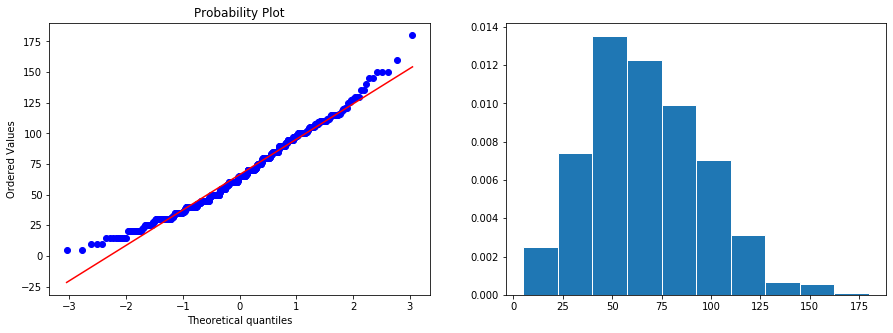

In [8]:
plt.figure(figsize=(15,5))

plt.subplot(121)
probplot(train['speed'], dist='norm', plot=plt)

plt.subplot(122)
plt.hist(train['speed'], density=True, edgecolor='w');

## Plot inicial
Como maneira de visualizar melhor se as variáveis tem relação ao *Target*, plotamos os gráficos *scatterplot* de relação entre as diversas variáveis quantitativas, além de separar por tipos de Pokémon, para ver se com isso conseguíamos visualizar alguma relação, que como se perceberá logo, é bem difícil.

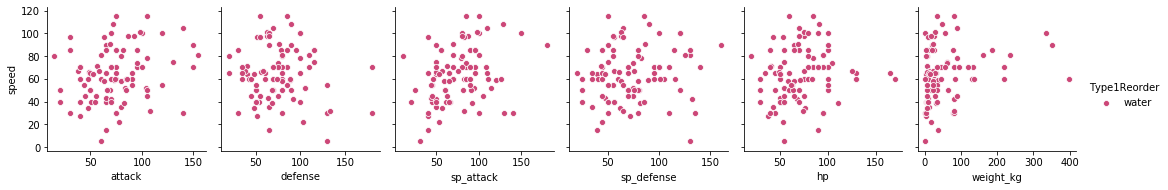

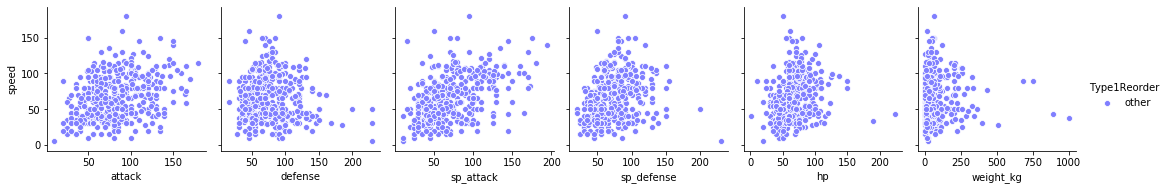

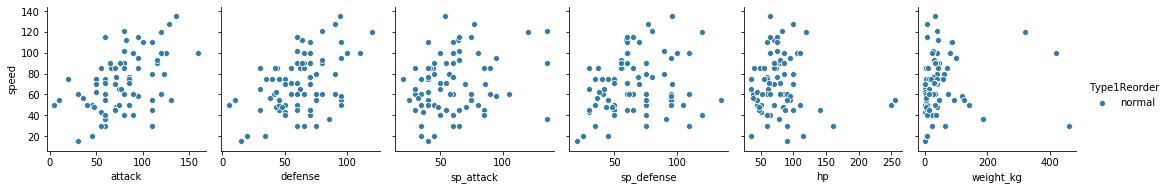

In [9]:
listType1 = train.Type1Reorder.unique()
listType2 = train.Type2Reorder.unique()
colorlist = ['plasma', 'cool', 'mako']

for i in range(3):
    e = listType1[i]
    df = train.loc[train.Type1Reorder==e, :]
    sns.pairplot(df, palette=colorlist[i],
        x_vars=["attack", 'defense', 'sp_attack', 'sp_defense', 'hp', 'weight_kg'],
        y_vars=['speed'],
        hue='Type1Reorder', height=2.5);

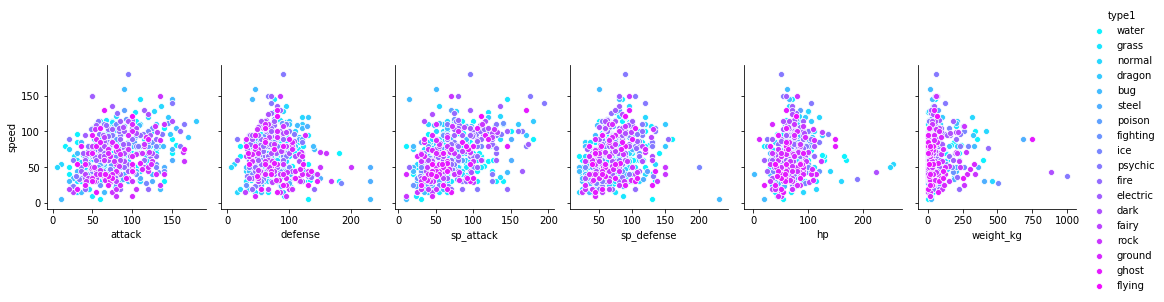

In [10]:
sns.pairplot(train,
        x_vars=["attack", 'defense', 'sp_attack', 'sp_defense', 'hp', 'weight_kg'],
        y_vars=['speed'], palette='cool',hue='type1', height=2.5);

## Regressão
Percebendo que assim não conseguiríamos identificar nenhuma relação, optamos por usar a biblioteca <b>statsmodel.api</b> para fazer a regressão pelo método dos Mínimos Quadrados. 

*Usamos apenas algumas variáveis, pois no contexto do dataframe e do jogo Pokémon sabemos que fazem referência a outros detalhes que não vão influenciar na velocidade do Pokémon, além de alguns conterem termos NaN, que atrapalham o uso deles como treino*

In [11]:
X = train[['attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'is_legendary', 'generation', 'experience_growth']]

Y = train[['speed']]

In [12]:
def regress(Y,X):
    '''
    Y: coluna do DataFrame utilizada como variável resposta (TARGET)
    X: coluna(s) do DataFrame utilizadas como variável(is) explicativas (FEATURES)
    '''
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    
    return results

In [13]:
results = regress(Y,X)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     34.64
Date:                Fri, 20 Nov 2020   Prob (F-statistic):           6.63e-45
Time:                        18:06:41   Log-Likelihood:                -2756.8
No. Observations:                 600   AIC:                             5532.
Df Residuals:                     591   BIC:                             5571.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                51.2575      7.800      6.572      0.000      35.939      66.576
attack                0.3356      0.038      8.742      0.000       0.260       0.411
defense              -0.3013      0.040     -7.444      0.000      -0.381      -0.222
sp_attack             0.2376      0.039      6.167      0.000       0.162       0.313
sp_defense            0.1452      0.047      3.059      0.002       0.052       0.238
hp                   -0.1124      0.043     -2.636      0.009      -0.196      -0.029
is_legendary         18.1856      4.164      4.367      0.000      10.007      26.364
generation           -1.5136      0.522     -2.900      0.004      -2.539      -0.489
experience_growth -4.314e-06    6.7e-06     -0.644      0.520   -1.75e-05    8.85e-06
==============================================================================
Omnibus:                       15.913   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.044
Skew:                           0.353   Prob(JB):                     0.000199
Kurtosis:                       3.427   Cond. No.                     8.73e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.73e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Analisando os resultados acima, percebemos que TODOS (com excessão de "experience_growth") são importantes para definir nossa variável *Target*, ou seja, a velocidade ("speed"). Apesar disso, nosso P é bem pequeno, o que não é um bom sinal, e portanto precisaremos de mais regressões se quisermos atingir a normalidade e poder prever fielmente nosso *Target*.

## Análise Rápida da previsão "como está"
Apenas para visualizarmos, abaixo segue o plot do predict (ou seja, a previsão que a biblioteca $sm$ faz) relacionado com os valores reais do nosso dataframe *teste*.

In [14]:
X_test = test[['attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'is_legendary', 'generation', 'experience_growth']]

Y_test = test[['speed']]

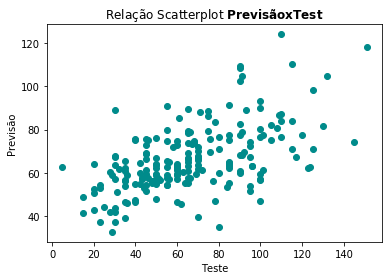

In [15]:
X_cp = sm.add_constant(X_test)
Y_predTest = results.predict(X_cp)

plt.title(r'Relação Scatterplot $\bf{Previsão x Test}$')
plt.xlabel('Teste')
plt.ylabel('Previsão')
plt.scatter(Y_test, Y_predTest, color='darkcyan');

## Aprofundamento na Análise Exploratória
Para aprimorarmos nossa previsão da velocidade dos Pokémons, precisamos também considerar variáveis <b>qualitativas</b>. Porém, a biblioteca $sm$ lida apenas com variáveis <b>quantitativas</b>. Como podemos então transformar essas variáveis para podermos analisar melhor nosso dataframe? A resposta é: com $Dummies$. Dummies é um comando da biblioteca $pandas$ que transforma as strings de uma classificação qualitativa em colunas de um dataframe assumindo valores de 0 ou 1, que equivalem a False e True, respectivamente. Assim, podemos usar essas novas colunas para uma análise exploratória mais aprofundada.

In [16]:
X_Types = train.iloc[:,43:]
X_Types 

,T1_bug,T2_bug,T1_dark,T2_dark,T1_dragon,T2_dragon,T1_electric,T2_electric,T1_fairy,T2_fairy,...,T1_poison,T2_poison,T1_psychic,T2_psychic,T1_rock,T2_rock,T1_steel,T2_steel,T1_water,T2_water
90,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
152,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
779,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
620,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
571,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
214,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
547,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
472,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
results = regress(Y,X_Types)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     3.431
Date:                Fri, 20 Nov 2020   Prob (F-statistic):           5.54e-10
Time:                        18:06:41   Log-Likelihood:                -2814.3
No. Observations:                 600   AIC:                             5701.
Df Residuals:                     564   BIC:                             5859.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          60.1139      1.945     30.913      0.000      56.294      63.933
T1_bug         -3.6450      4.407     -0.827      0.408     -12.301       5.010
T2_bug         -6.0528     13.864     -0.437      0.663     -33.283      21.178
T1_dark        10.9682      6.175      1.776      0.076      -1.160      23.096
T2_dark        14.9674      7.335      2.040      0.042       0.559      29.376
T1_dragon      10.8716      5.900      1.843      0.066      -0.718      22.461
T2_dragon       2.2312      7.880      0.283      0.777     -13.247      17.709
T1_electric    20.7038      5.084      4.072      0.000      10.718      30.690
T2_electric     0.5552     11.488      0.048      0.961     -22.009      23.119
T1_fairy      -12.2809      7.362     -1.668      0.096     -26.741       2.179
T2_fairy       -2.2664      6.867     -0.330      0.742     -15.755      11.223
T1_fighting     3.3862      5.651      0.599      0.549      -7.714      14.486
T2_fighting    19.6914      7.571      2.601      0.010       4.821      34.561
T1_fire         7.5065      4.408      1.703      0.089      -1.151      16.164
T2_fire        -1.3720     11.710     -0.117      0.907     -24.372      21.628
T1_flying      26.7706     18.574      1.441      0.150      -9.713      63.254
T2_flying      22.0856      3.675      6.010      0.000      14.867      29.304
T1_ghost       -4.2322      5.931     -0.714      0.476     -15.882       7.418
T2_ghost       -0.5375      7.960     -0.068      0.946     -16.173      15.098
T1_grass       -4.4589      4.031     -1.106      0.269     -12.377       3.459
T2_grass       -1.6610      7.294     -0.228      0.820     -15.987      12.665
T1_ground      -2.7548      5.259     -0.524      0.601     -13.085       7.575
T2_ground      -4.5542      5.920     -0.769      0.442     -16.181       7.073
T1_ice          2.4856      6.272      0.396      0.692      -9.833      14.804
T2_ice          9.0524      7.591      1.193      0.234      -5.857      23.962
T1_normal       4.6123      3.383      1.363      0.173      -2.033      11.258
T2_normal      15.0310     14.034      1.071      0.285     -12.534      42.596
T1_poison      -3.6297      6.039     -0.601      0.548     -15.492       8.232
T2_poison      12.4068      5.961      2.081      0.038       0.698      24.116
T1_psychic     17.0320      4.580      3.719      0.000       8.037      26.027
T2_psychic      5.4413      6.354      0.856      0.392      -7.039      17.921
T1_rock        -6.2900      4.806     -1.309      0.191     -15.729       3.149
T2_rock       -21.5379      8.077     -2.667      0.008     -37.402      -5.674
T1_steel       -8.2692      6.843     -1.208      0.227     -21.710       5.172
T2_steel        0.4777      6.959      0.069      0.945     -13.191      14.147
T1_water        1.3378      3.111      0.43

## Analisando a regressão da variável Tipo 1
Analisando essa primeira tabela da regressão, percebe-se uma forte relação dos tipos electric, fire, flying e psychic com a velocidade. Seguimos aprofundando na análise. 

In [18]:
# X_Type1 = dummies_type1.loc[:, ['electric', 'fire', 'flying', 'psychic']]
# results = regress(Y,X_Type1)
# results.summary()

## Analisando a regressão da variável Tipo 2
Analisando essa tabela da regressão, percebe-se uma forte relação dos tipos 2 fighting, flying, rock e water com a velocidade. Seguimos aprofundando na análise. 

In [19]:
# X_Type2 = dummies_type2.loc[:, ['fighting', 'flying', 'rock', 'water']]
# results = regress(Y,X_Type2)
# results.summary()

## Analisando a regressão da variável dos tipos
Analisando a tabela de regressão, percebe-se uma forte relação dos tipos escolhidos com a velocidade. Essa escolha foi feita a base de um alfa de 5%.

In [20]:
X_Types_Imp = X_Types.loc[:,['T2_dark','T1_electric','T2_fighting', 'T1_flying', 'T2_flying', 
                             'T1_psychic', 'T2_psychic', 'T2_rock']]

In [21]:
results = regress(Y,X_Types_Imp)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     11.23
Date:                Fri, 20 Nov 2020   Prob (F-statistic):           7.38e-15
Time:                        18:06:41   Log-Likelihood:                -2829.7
No. Observations:                 600   AIC:                             5677.
Df Residuals:                     591   BIC:                             5717.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          61.0752      1.343     45.473      0.000      58.437      63.713
T2_dark        13.0582      7.161      1.823      0.069      -1.006      27.123
T1_electric    20.6438      5.132      4.023      0.000      10.565      30.722
T2_fighting    21.0169      7.396      2.842      0.005       6.491      35.543
T1_flying      26.9248     19.311      1.394      0.164     -11.001      64.851
T2_flying      22.4773      3.473      6.471      0.000      15.656      29.299
T1_psychic     15.7106      4.648      3.380      0.001       6.581      24.840
T2_psychic      6.3534      6.095      1.042      0.298      -5.617      18.323
T2_rock       -24.9982      7.674     -3.257      0.001     -40.071      -9.926
==============================================================================
Omnibus:                       20.501   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.977
Skew:                           0.469   Prob(JB):                     1.69e-05
Kurtosis:                       3.009   Cond. No.                         17.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regressão Aprofundada
Agora que temos alguma noção de quais variáveis importam para nós e quais não, podemos fazer uma regressão apenas com essas variáveis, e ver se conseguimos usar esse modelo para prever com mais precisão a base de *teste*.

In [22]:
# # Type1 importantes: electric, fire, flying, psychic
# # Type2 importantes: fighting, flying, rock, water

# Type1Imp = ['electric', 'fire', 'flying', 'psychic']
# Type2Imp = ['fighting', 'flying', 'rock', 'water']

# # Usaremos essas listas para criar colunas personalizadas no dataframe Train para poder diferenciar type1 de type2
# # Assim, já podemos aproveitar e usar os dataframse de Dummies para isso

# for i in range(4):
#     train.loc[:,'T1_'+Type1Imp[i]] = dummies_type1[Type1Imp[i]]
#     train.loc[:,'T2_'+Type2Imp[i]] = dummies_type2[Type2Imp[i]]
    
# train

In [23]:
X_comp = train[['attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'is_legendary', 'generation','T2_dark',
                'T1_electric','T2_fighting', 'T1_flying', 'T2_flying', 'T1_psychic', 'T2_psychic', 'T2_rock']]

In [24]:
results = regress(Y,X_comp)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     23.30
Date:                Fri, 20 Nov 2020   Prob (F-statistic):           3.55e-50
Time:                        18:06:41   Log-Likelihood:                -2731.5
No. Observations:                 600   AIC:                             5495.
Df Residuals:                     584   BIC:                             5565.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           42.4533      4.237     10.019      0.000      34.131      50.776
attack           0.3260      0.038      8.601      0.000       0.252       0.400
defense         -0.2496      0.042     -5.975      0.000      -0.332      -0.168
sp_attack        0.1986      0.038      5.177      0.000       0.123       0.274
sp_defense       0.1414      0.046      3.070      0.002       0.051       0.232
hp              -0.1006      0.041     -2.439      0.015      -0.182      -0.020
is_legendary    14.6276      4.027      3.632      0.000       6.718      22.538
generation      -1.4762      0.507     -2.909      0.004      -2.473      -0.480
T2_dark          6.8718      6.168      1.114      0.266      -5.242      18.986
T1_electric     12.1286      4.529      2.678      0.008       3.233      21.024
T2_fighting     10.3448      6.462      1.601      0.110      -2.347      23.037
T1_flying       20.9156     16.642      1.257      0.209     -11.769      53.600
T2_flying       18.9154      2.985      6.336      0.000      13.052      24.779
T1_psychic       6.2166      4.256      1.461      0.145      -2.143      14.576
T2_psychic       2.5185      5.271      0.478      0.633      -7.834      12.870
T2_rock        -10.1037      7.001     -1.443      0.150     -23.854       3.647
==============================================================================
Omnibus:                       15.438   Durbin-Watson:                   1.822
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.025
Skew:                           0.369   Prob(JB):                     0.000331
Kurtosis:                       3.310   Cond. No.                     2.98e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [56]:
# T2_dark, T2_fighting, T1_flying, T1_psychic, T2_psychic e T2_rock não são importantes, e podemos descartá-los

X_comp = train[['attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'is_legendary', 'generation',
                'T1_electric', 'T2_flying']]

results = regress(Y,X_comp)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     37.61
Date:                Fri, 20 Nov 2020   Prob (F-statistic):           9.51e-53
Time:                        18:14:23   Log-Likelihood:                -2736.2
No. Observations:                 600   AIC:                             5492.
Df Residuals:                     590   BIC:                             5536.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           43.3706      4.222     10.273      0.000      35.079      51.662
attack           0.3312      0.037      8.949      0.000       0.258       0.404
defense         -0.2771      0.039     -7.048      0.000      -0.354      -0.200
sp_attack        0.2090      0.038      5.526      0.000       0.135       0.283
sp_defense       0.1504      0.046      3.290      0.001       0.061       0.240
hp              -0.1074      0.041     -2.601      0.010      -0.188      -0.026
is_legendary    17.2371      3.871      4.453      0.000       9.635      24.839
generation      -1.3497      0.505     -2.671      0.008      -2.342      -0.357
T1_electric     10.5737      4.489      2.355      0.019       1.757      19.390
T2_flying       18.2624      2.970      6.149      0.000      12.429      24.096
==============================================================================
Omnibus:                       15.075   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.633
Skew:                           0.363   Prob(JB):                     0.000403
Kurtosis:                       3.313   Cond. No.                         876.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Ajustando o Dataframe *Test*
Sabendo o que estamos indo atrás agora, para podermos usar o comando *.predict*, precisamos preparar o df *test* para ter as mesmas colunas relativas a ele que usaremos no df *train*. As próximas células fazem exatamente isso.

In [58]:
# Como a regressão não melhorou nosso R-squared, utilizaremos o anterior para fazer um teste do data frame
X_comp = train[['attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'is_legendary', 'generation','T2_dark',
                'T1_electric','T2_fighting', 'T1_flying', 'T2_flying', 'T1_psychic', 'T2_psychic', 'T2_rock']]

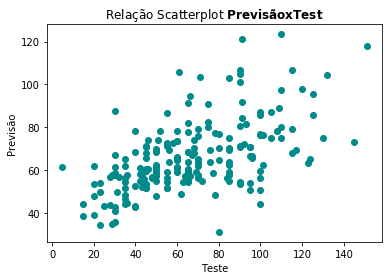

In [59]:
X_cnt = sm.add_constant(X_TesteComp)
Y_predTest = results.predict(X_cnt)

plt.title(r'Relação Scatterplot $\bf{Previsão x Test}$')
plt.xlabel('Teste')
plt.ylabel('Previsão')
plt.scatter(Y_test, Y_predTest, color='darkcyan');

In [63]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=0)

X_comp = train[['attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'is_legendary', 'generation','T2_dark',
                'T1_electric','T2_fighting', 'T1_flying', 'T2_flying', 'T1_psychic', 'T2_psychic', 'T2_rock']]

regressor.fit(X_comp, Y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [64]:
regressor.score(X_comp, Y)

0.9978271593237471

In [62]:
#arvore tende a ir bem em cima do treinamento dela

In [65]:
X_comp

,attack,defense,sp_attack,sp_defense,hp,is_legendary,generation,T2_dark,T1_electric,T2_fighting,T1_flying,T2_flying,T1_psychic,T2_psychic,T2_rock
90,95,180,85,45,50,0,1,0,0,0,0,0,0,0,0
152,62,80,63,80,60,0,2,0,0,0,0,0,0,0,0
779,60,85,135,91,78,0,7,0,0,0,0,0,0,0,0
620,120,90,60,90,77,0,5,0,0,0,0,0,0,0,0
571,50,40,40,40,55,0,5,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,57,40,40,40,46,0,1,0,0,0,0,0,0,0,0
214,95,55,35,75,55,0,2,0,0,0,0,0,0,0,0
547,35,50,70,50,45,0,5,0,0,0,0,0,0,0,0
472,130,80,70,60,110,0,4,0,0,0,0,0,0,0,0


In [74]:
X_TesteComp = test.loc[:, X_comp.columns]

In [77]:
regressor.score(X_TesteComp, Y_test)

-0.22520756823173782